In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.impute import KNNImputer 
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import mode
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier # predict a target variable by combining weaker models.
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Feature Information

- **PassengerId:** id of passenger
- **Survival:** 0 = No, 1 = Yes
- **pclass:** (Ticket class)

   - 1 = 1st, 2 = 2nd, 3 = 3rd
   - 1st = Upper / 2nd = Middle /3rd = Lower
- **Name:** name of the passanger
- **sex:** male/female
- **Age:** Age in years (Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5)
- **sibsp:** # of siblings / spouses aboard the Titanic

The dataset defines family relations in this way...

    - Sibling = brother, sister, stepbrother, stepsister
    - Spouse = husband, wife (mistresses and fiancés were ignored)
    
- **parch:** # of parents / children aboard the Titanic

    The dataset defines family relations in this way...

       - Parent = mother, father
       - Child = daughter, son, stepdaughter, stepson
       - Some children travelled only with a nanny, therefore parch=0 for them.
- **ticket:** Ticket number
- **fare:** Passenger fare
- **cabin:** Cabin number
- **embarked:** Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton
----

## EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- So, we have 2 featues filled with float values, 5 integer features, 5 object features.

In [4]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

- we have null values in 3 featues(Age, Cabin, Embarked)

In [5]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

- We also have null values in the testing data set. So, we have to impute them.

In [6]:
df["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

- Data is imbalanced

In [7]:
# defining a function to check how much people are survived or non_survived
def get_value_counts(data):
    plt.figure(figsize = (10,3))
    plot = sns.countplot(hue = df["Survived"], x= df[data])
    return plot

<AxesSubplot: xlabel='Pclass', ylabel='count'>

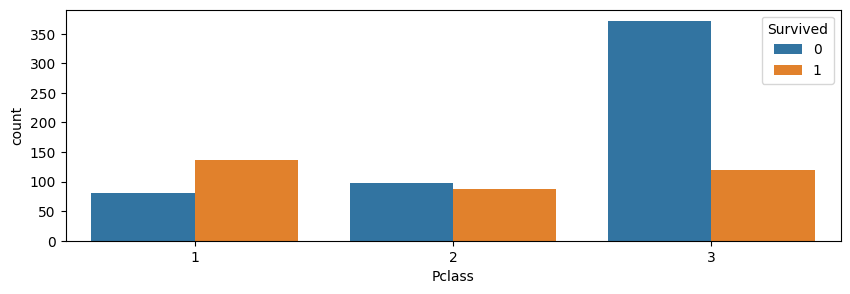

In [8]:
get_value_counts("Pclass")

- Here we see passanger class 1, In class 2 the passanger survived and non_survived nearly equal. But the highest non-survived passangers are in class 3.

<AxesSubplot: xlabel='Sex', ylabel='count'>

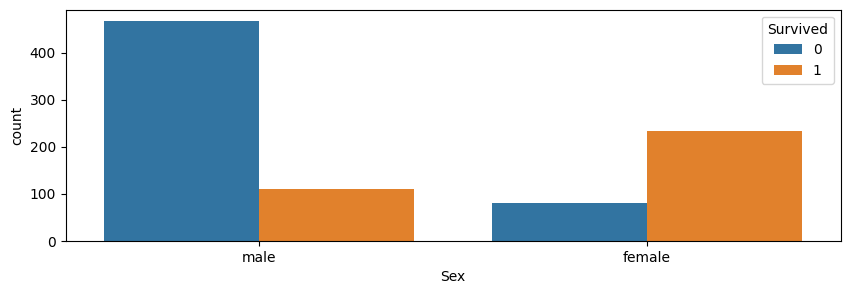

In [9]:
get_value_counts("Sex")

- The death rate of male are much higher than female. Most of the female are survived

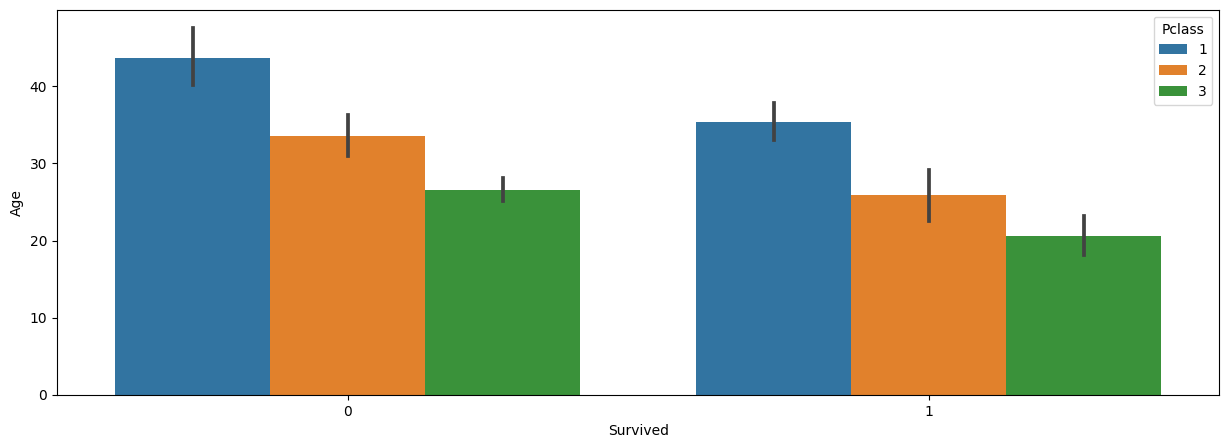

In [14]:
plt.figure(figsize = (15,5))
sns.barplot(x=df["Survived"],y=df["Age"],hue = df["Pclass"])
plt.show()

<AxesSubplot: xlabel='SibSp', ylabel='count'>

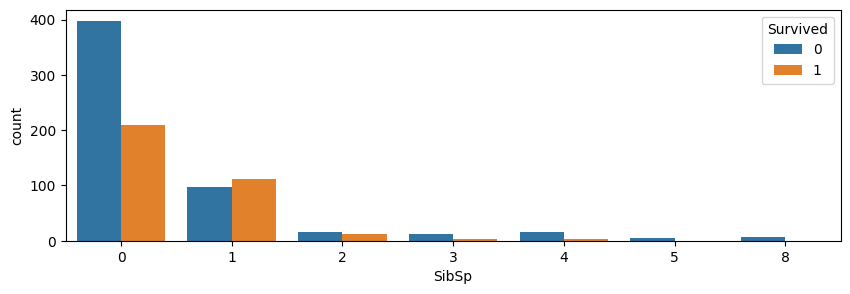

In [15]:
get_value_counts("SibSp")

- people who are travelling alone are highest non_survival. and who has one sibling are survived more then non survived.

<AxesSubplot: xlabel='Parch', ylabel='count'>

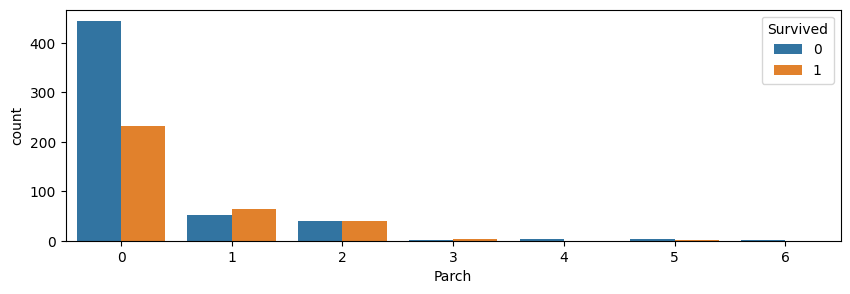

In [16]:
get_value_counts("Parch")

- children who are traveling only with a nanny are the most non_suvived.

<AxesSubplot: xlabel='Embarked', ylabel='count'>

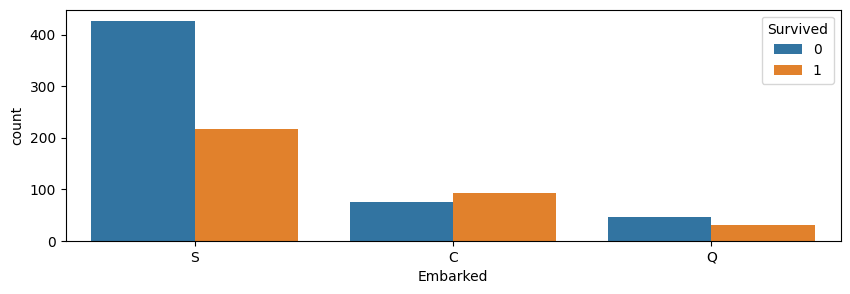

In [17]:
get_value_counts("Embarked")

- Here we can see Port of Embarkation Cherbourg has higer survival rate. Queenstown, Southampton has high non_survival rate.

<AxesSubplot: >

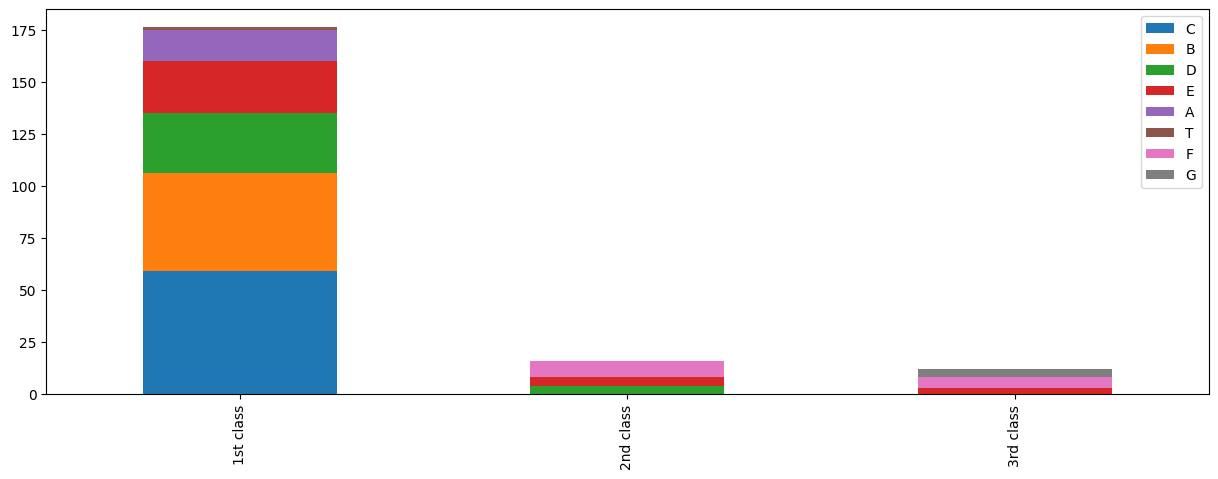

In [21]:
df1 = df
for i in (df1,):
    i["Cabin"] = i["Cabin"].str[0:1]
pcl1 = df1[df1["Pclass"]==1]["Cabin"].value_counts()
pcl2 = df1[df1["Pclass"]==2]["Cabin"].value_counts()
pcl3 = df1[df1["Pclass"]==3]["Cabin"].value_counts()
_temp = pd.DataFrame([pcl1,pcl2,pcl3],index = ["1st class","2nd class","3rd class"])
_temp.plot(kind="bar",stacked = True, figsize=(15,5))

- Here most 1st class passangers are in A cabin then E cabin. And 2nd class passengers are in f cabin. G cabin have the 3rd class passsangers

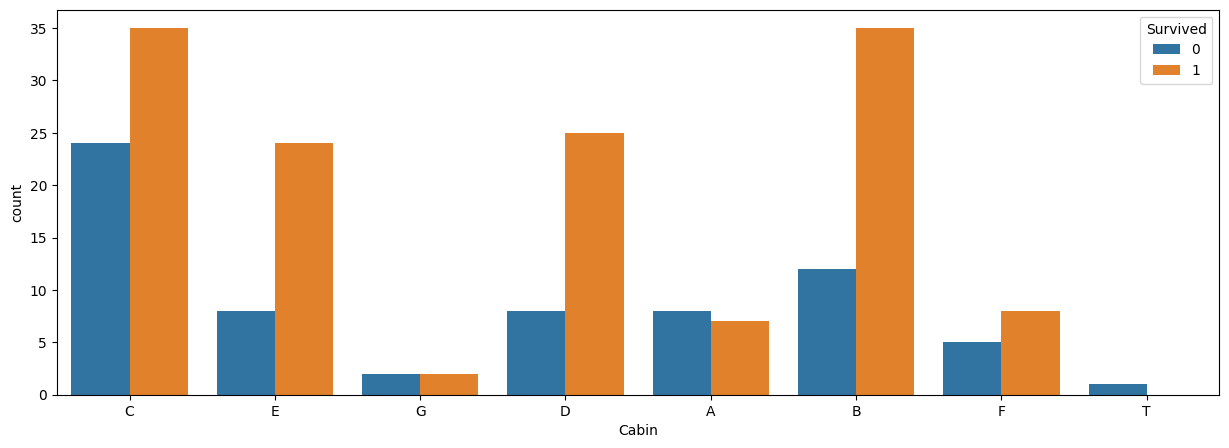

In [23]:
plt.figure(figsize = (15,5))
sns.countplot(x=df1["Cabin"], hue = df1["Survived"])
plt.show()

- Here we can see cabin C is the highest survived and non-survived passangers class, in second place comes class B